# **CNN Encoder Decoder SE Block with COCO using pretrained ResNet18**

In this computational notebook, we have implemented a convolutional autoencoder that incorporates a pretrained ResNet18 model for the encoder part. The purpose of using the pretrained ResNet18 is to leverage its learned features from the ImageNet dataset, allowing for fine-tuning and accelerated training. The decoder part of the autoencoder consists of a deconvolution architecture with four layers, which receives information from the pretrained ResNet18 model and incorporates a Squeeze-and-Excitation (SE) block. The SE block strategically integrates within the encoder-decoder modules to enhance the model's performance by emphasizing the most relevant filters for the color reconstruction task.

This design adaptation is specifically tailored to address the color reconstruction task, primarily focusing on our dataset that comprises various facial images. We have diligently utilized this dataset for both the training and testing processes, providing a comprehensive and relevant knowledge base for the model to learn from.

For readers seeking a deeper understanding and technical insights into Squeeze-and-Excitation Networks, we recommend referring to the scholarly work titled "Squeeze-and-Excitation Networks" by Hu et al., which was presented at the Computer Vision and Pattern Recognition (CVPR) conference in 2018.

During the training of this model, we utilized a subset of the COCO dataset for validation purposes, which consists of 5000 images. The use of this reduced dataset was done to ensure simplicity and reasonable training time without compromising the overall model performance.

# Import necessary libraries

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import matplotlib.pyplot as plt
import zipfile
import io
from google.colab import files
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
from skimage import color
import requests

# Connect to GPU if availble 

*Clear the CUDA memory cache. This releases all unoccupied cached memory so that those can be used by CUDA operations if necessary. This can help prevent the CUDA out-of-memory errors that can occur when the memory is filled up with cached, but unused data.*

In [23]:
torch.cuda.empty_cache()

In [24]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Utils

In [25]:
url = "http://images.cocodataset.org/zips/val2017.zip"  # Replace with the URL of the dataset file
save_path = "dataset.zip"  # Replace with the desired save path

response = requests.get(url)
with open(save_path, "wb") as f:
    f.write(response.content)

In [26]:
# Specify the file name of the uploaded ZIP file
zip_filename = "DeepColorization-master.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(save_path, "r") as zip_ref:
    zip_ref.extractall("face_images")

In [27]:
# Path to the extracted dataset folder
dataset_folder_path = "face_images/val2017"

# Get the list of image files in the dataset folder
image_files = [f for f in os.listdir(dataset_folder_path) if os.path.isfile(os.path.join(dataset_folder_path, f))]

In [28]:
# Create directories for training and validation sets
train_folder = "dataset/train"
val_folder = "dataset/val"

# Create the directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [29]:
# Shuffle the image files list
random.shuffle(image_files)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

# Split the image files list into training and validation sets
train_image_files = image_files[:split_index]
val_image_files = image_files[split_index:]

In [30]:
# Iterate through the training set image files
for i, image_name in enumerate(train_image_files):
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    colored_image_path = os.path.join(train_folder, image_name)
    image.save(colored_image_path)

In [31]:
# Iterate through the validation set image files
for image_name in val_image_files:
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    # Save the colored image in the validation folder
    colored_image_path = os.path.join(val_folder, image_name)
    image.save(colored_image_path)

# RGB Colorspace

*Define the class that will generate the grayscale and the colored image in RGB. Pretrained model just accepts 3 RGB channels.*

In [32]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        # Get the image name and path based on the index
        image_name = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_name)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Convert the image to LAB colorspace
        lab_image = np.array(image)
        
        if lab_image.shape[-1] == 3:
            # Image has three channels (already colored)
            
            # Convert the image to grayscale
            image_gray = image.convert("L")
            
            # Create auxiliary tensor of zeros for A and B channels
            auxiliar = torch.zeros((128,128))
            
            # Apply transform to grayscale image
            image_gray = self.transform(image_gray)
            image_gray = image_gray.squeeze(0)
            
            # Create input tensor with grayscale image and zeros for A and B channels
            inp_gray = torch.stack((image_gray, auxiliar, auxiliar), axis=0)
            
            # Apply transform to original colored image
            lab_image = self.transform(lab_image)
            
            return inp_gray, lab_image  # Return grayscale image as input and colored image as target
        else:
            # Image has less than three channels (e.g., grayscale or alpha channel)
            
            # Create empty tensor for A and B channels
            lab_image = np.zeros((2, 128, 128))
            
            # Convert the image to grayscale
            image_gray = image.convert("L")
            
            # Create auxiliary tensor of zeros for A and B channels
            auxiliar = torch.zeros((128, 128))
            
            # Apply transform to grayscale image
            image_gray = self.transform(image_gray)
            image_gray = image_gray.squeeze(0)
            
            # Create input tensor with grayscale image and zeros for A and B channels
            inp_gray = torch.stack((image_gray, auxiliar, auxiliar), axis=0)
            
            return inp_gray, inp_gray  # Return grayscale image as input and target

In [33]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
   
    
])
# Define the path to your dataset directory
dataset_root = "dataset/"

# Create an instance of the custom dataset
train_dataset = ColorizationDataset(os.path.join(dataset_root, "train"), transform=transform)

#Instance of the custom validation dataset
test_dataset = ColorizationDataset(os.path.join(dataset_root, "val"), transform=transform)

# Define the batch size for the DataLoader
batch_size = 256

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Model

*Tried to finetune the pretrained model and use the respresentation of this model to reconstruct the original color.*

In [34]:
def freeze_model(model):
    """
    Freezes the parameters of a model, making them untrainable during optimization.
    
    Args:
        model: The model to freeze.
    """
    for param in model.parameters():
        # Set requires_grad to False for each parameter
        param.requires_grad = False

In [35]:
def create_model():
    """
    Creates a model based on the ResNet18 architecture, with pretrained weights and frozen parameters.
    
    Returns:
        The created model.
    """
    # Load the pretrained ResNet18 model
    resnet = models.resnet18(pretrained=True)
    
    # Get the list of modules from the ResNet18 model, excluding the last two layers
    modules = list(resnet.children())[:len(list(resnet.children()))-2]
    
    # Create a new sequential model with the desired modules
    res_model = torch.nn.Sequential(*modules)
    
    # Load the state dict of the pretrained ResNet18 into the new model
    res_model.load_state_dict(resnet.state_dict(), strict=False)
    
    # Freeze the parameters of the new model
    freeze_model(res_model)

    return res_model

*Tried to finetune the pretrained encoder initialized with the it's pretrained weights.*

*Also, tried to add more layers to have a more flexible and bigger model.*

In [36]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # Convolutional layers for encoding
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)  # b, 16, 64, 64
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # b, 32, 32, 32
        self.conv3 = nn.Conv2d(32, 512, 3, stride=2, padding=1)  # b, 64, 16, 16

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)

        # Deconvolutional layers for decoding
        self.deconv1 = nn.ConvTranspose2d(512, 384, 3, stride=3, padding=0, output_padding=0)  # b, 64, 12 , 12
        self.deconv2 = nn.ConvTranspose2d(384, 256, 3, stride=2, padding=0, output_padding=0)  # b, 48, 25, 25
        self.deconv3 = nn.ConvTranspose2d(256, 128, 3, stride=1, padding=0, output_padding=0)  # b, 32, 27, 27
        self.deconv4 = nn.ConvTranspose2d(128, 64, 5, stride=2, padding=0, output_padding=0)  # b, 16, 57, 57
        self.deconv5 = nn.ConvTranspose2d(64, 32, 5, stride=1, padding=0, output_padding=0)  # b, 8, 61, 61
        self.deconv6 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=0, output_padding=0)  # b, 3, 125, 125
        self.deconv7 = nn.ConvTranspose2d(16, 3, 4, stride=1, padding=0, output_padding=0)  # b, 3, 128, 128

    def encoder(self, x):
        # Create and load the pretrained ResNet model for encoding
        res_model = create_model()
        res_model.to(device)
        x = res_model(x)
        
        return x

    def attention(self, x):
        # Squeeze-and-Excitation attention mechanism
        batch_size, channels, height, width = x.size()

        # Squeeze (global average pooling)
        squeeze = self.pooling(x).view(batch_size, channels)

        # Excitation (fully connected layers)
        excitation = torch.nn.functional.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))

        # Re-calibration
        excitation = excitation.view(batch_size, channels, 1, 1)
        scaled_feature = x * excitation.expand_as(x)
        
        return scaled_feature

    def decoder(self, x):
        # Deconvolutional layers for decoding
        x = self.deconv1(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv2(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv3(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv4(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv5(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv6(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv7(x)

        return x

    def forward(self, x):
        # Forward pass through the autoencoder
        encoded = self.encoder(x)
        att = self.attention(encoded)
        decoded = self.decoder(att)
        
        return decoded

In [37]:
model = ConvAE().to(device)

# create an optimizer object
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
              
# mean-squared error loss
criterion = nn.MSELoss()

# Training and Validation

In [38]:
# Define a function to train the model
def train(model, loader, optimizer, criterion, reshape=False):
    # Initialize the loss to 0
    loss = 0
    # Set the model to training mode
    model.train()

    # Iterate over all batches in the loader
    for batch_features, feat in loader:
        # Move the batch features and labels to the device the model is running on
        batch_features = batch_features.to(device)
        feat = feat.to(device)

        # Optionally reshape the batch features from [N, C, H, W] to [N, 784] 
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # Reset the gradients in the optimizer
        optimizer.zero_grad()
        
        # Forward propagate the batch through the model
        outputs = model(batch_features)
        
        # Compute the loss between the model output and actual labels
        train_loss = criterion(outputs, feat)
        
        # Backward propagate the loss through the model
        train_loss.backward()
        
        # Perform a step of optimization
        optimizer.step()
        
        # Add the batch loss to the total loss for the epoch
        loss += train_loss.item()

    # Compute the average epoch loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))
    return loss

# Define a function to test the model
def test(model, loader, criterion, reshape=False):
    # Initialize the loss to 0
    loss = 0
    # Set the model to evaluation mode
    model.eval()
    
    # Iterate over all batches in the loader
    for batch_features, feat in loader:
        # Move the batch features and labels to the device the model is running on
        batch_features = batch_features.to(device)
        feat = feat.to(device)
        
        # Optionally reshape the batch features from [N, C, H, W] to [N, 784] 
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # Wrap the forward pass in torch.no_grad to save memory during testing
        with torch.no_grad():
            # Forward propagate the batch through the model
            outputs = model(batch_features)
        
        # Compute the loss between the model output and actual labels
        test_loss = criterion(outputs,feat)
 
        # Add the batch loss to the total loss for the epoch
        loss += test_loss.item()
    
    # Compute the average epoch loss
    loss = loss / len(loader)
    
    # Display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    
    
    return loss

*Run the training and test.*

epoch : 1/10, Train loss = 0.203245
epoch : 1/10, Test loss = 0.109351
epoch : 2/10, Train loss = 0.100311
epoch : 2/10, Test loss = 0.090010
epoch : 3/10, Train loss = 0.081347
epoch : 3/10, Test loss = 0.072139
epoch : 4/10, Train loss = 0.069322
epoch : 4/10, Test loss = 0.065265
epoch : 5/10, Train loss = 0.064614
epoch : 5/10, Test loss = 0.061825
epoch : 6/10, Train loss = 0.060683
epoch : 6/10, Test loss = 0.059592
epoch : 7/10, Train loss = 0.057815
epoch : 7/10, Test loss = 0.058562
epoch : 8/10, Train loss = 0.054806
epoch : 8/10, Test loss = 0.055306
epoch : 9/10, Train loss = 0.053506
epoch : 9/10, Test loss = 0.051389
epoch : 10/10, Train loss = 0.051226
epoch : 10/10, Test loss = 0.051468


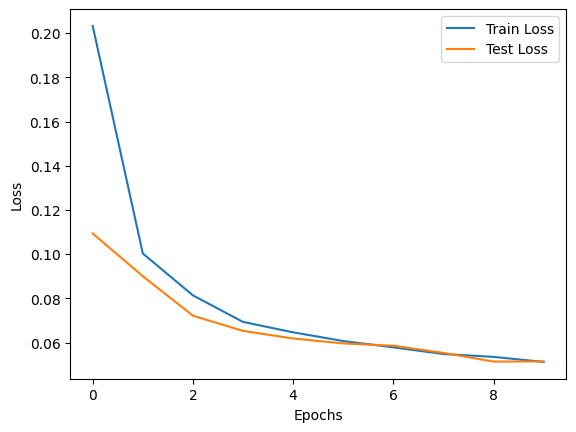

In [39]:
# Determine if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of epochs for training
epochs = 10

# Initialize lists to store loss values for each epoch
train_loss_list = []
test_loss_list = []

# Training loop 
for epoch in range(epochs):
    # Train the model on the training data and get the training loss
    train_loss = train(model, train_loader, optimizer, criterion, reshape=False)
    
    # Test the model on the testing data and get the testing loss
    test_loss = test(model, test_loader, criterion, reshape=False)

    # Append the training and testing loss for this epoch to their respective lists
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

# Plotting the loss curve

# Plot the training loss over epochs
plt.plot(train_loss_list, label='Train Loss')

# Plot the testing loss over epochs
plt.plot(test_loss_list, label='Test Loss')

# Label the x-axis as 'Epochs'
plt.xlabel('Epochs')

# Label the y-axis as 'Loss'
plt.ylabel('Loss')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Results with test

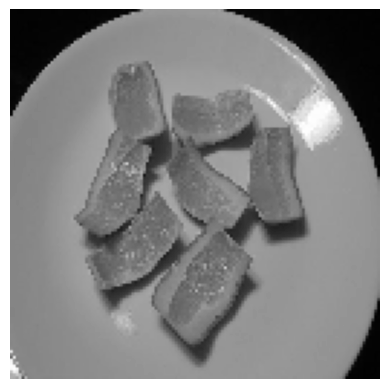

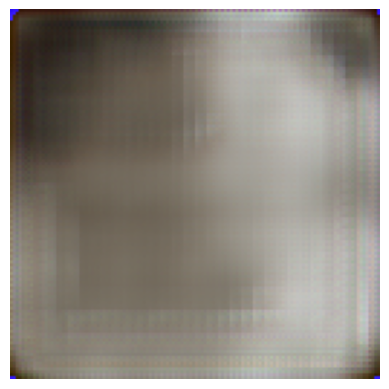

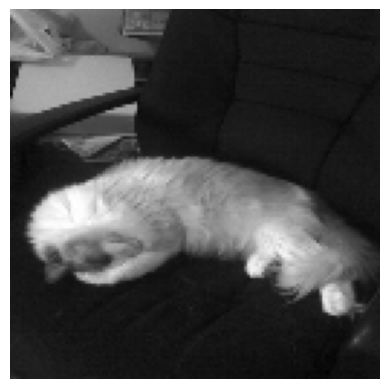

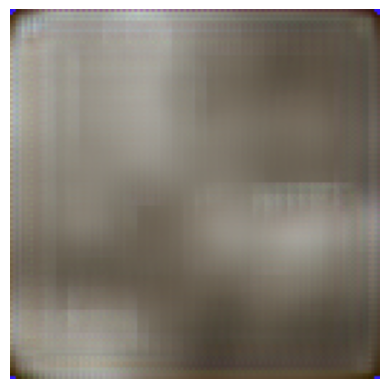

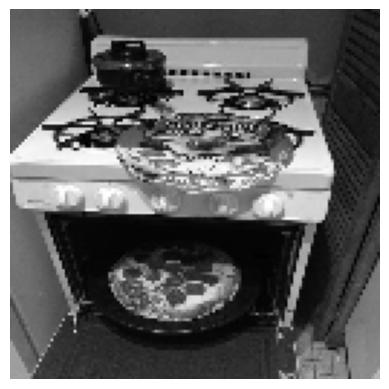

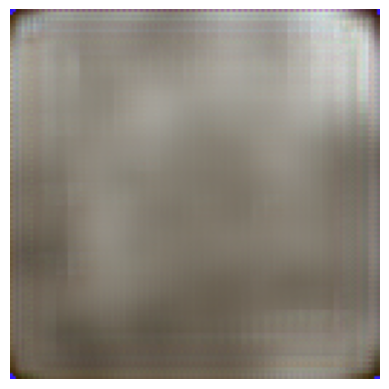

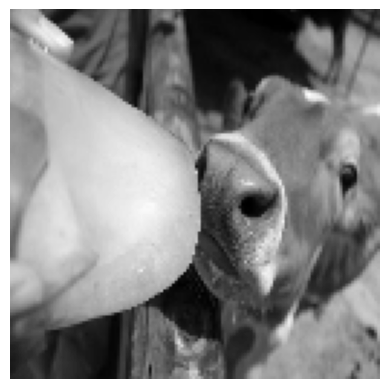

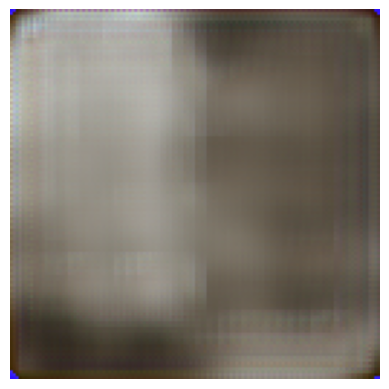

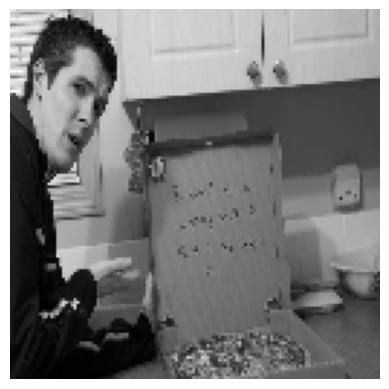

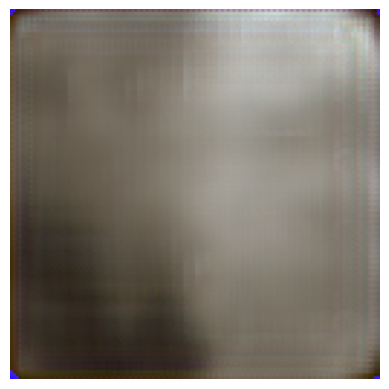

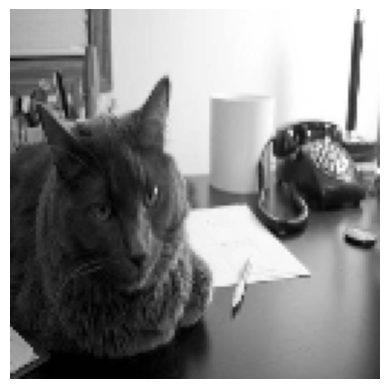

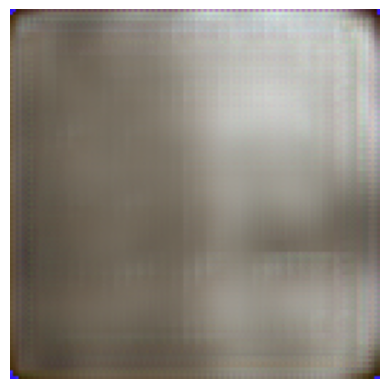

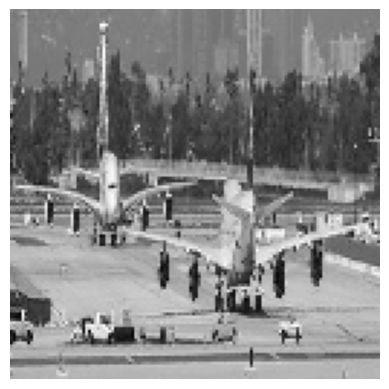

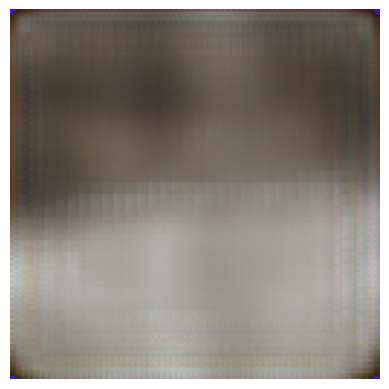

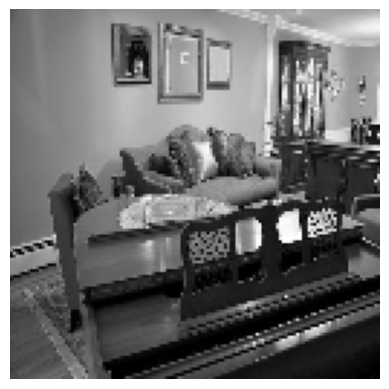

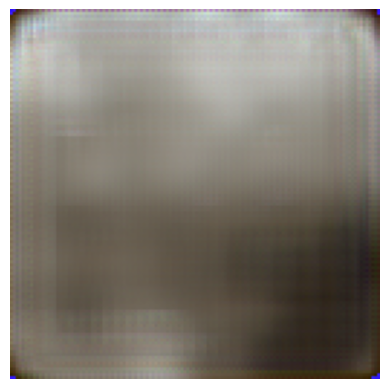

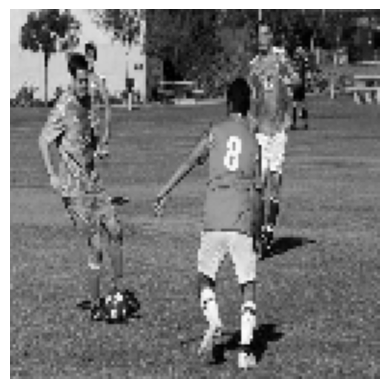

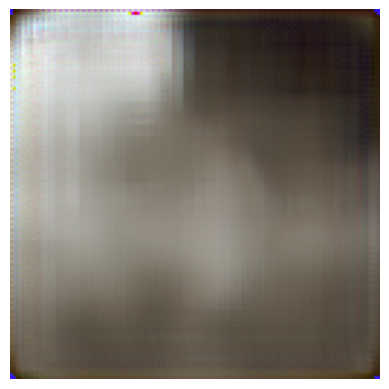

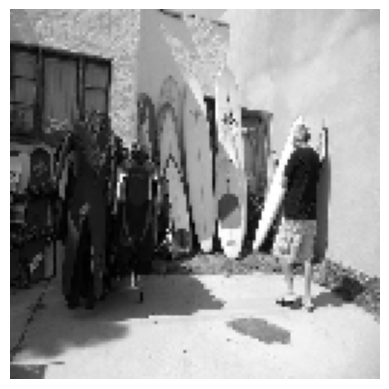

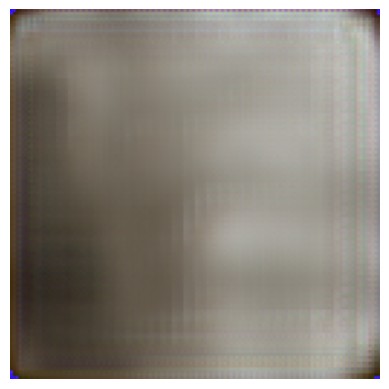

In [41]:
# Set the model to evaluation mode
model.eval()

# Plot the original grayscale images and their reconstructed colored images
test_images = 10

for i, image_name in enumerate(test_dataset):
    if i < test_images:
        # Get the grayscale image and the complete input tensor
        gray_image = image_name[0][0]
        gray_image_complete = image_name[0]
        
        # Display the original grayscale image
        plt.imshow(gray_image, cmap="gray")
        plt.axis('off')
        plt.show()

        # Preprocess the grayscale image and pass it through the model
        with torch.no_grad():
            colored_image = model(gray_image_complete.unsqueeze(0).to(device))

        # Convert the output tensor to an RGB image
        colored_image = colored_image.view(3, 128, 128)
        colored_image = colored_image.squeeze(0).cpu()
        colored_image = TF.to_pil_image(colored_image)

        # Display the reconstructed colored image
        plt.imshow(colored_image)
        plt.axis('off')
        plt.show()